#    # COVID19 DETECTION FROM 3D CT SCAN IMAGES 

In [1]:
## COVID19 DETECTION USING CT SCAN

# IMPORTING LIBRARIES

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np


from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


print("All libraries are imported")

All libraries are imported


# Define the variables and path

In [2]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 200
batch_size = 16

#define paths
covid_path = 'CT_COVID'
noncovid_path = 'CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [3]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("_________________________________________________________________________________________________________________________")
print("Total Count: ",len(covid_files))
print("_________________________________________________________________________________________________________________________")
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("_________________________________________________________________________________________________________________________")
print("Total Count: ",len(noncovid_files))


First 5 Covid Files:  ['CT_COVID\\2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png', 'CT_COVID\\2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png', 'CT_COVID\\2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png', 'CT_COVID\\2020.01.24.919183-p27-132.png', 'CT_COVID\\2020.01.24.919183-p27-133.png']
_________________________________________________________________________________________________________________________
Total Count:  349
_________________________________________________________________________________________________________________________
First 5 NonCovid Files:  ['CT_NonCOVID\\0.jpg', 'CT_NonCOVID\\1%0.jpg', 'CT_NonCOVID\\1%1.jpg', 'CT_NonCOVID\\1%2.jpg', 'CT_NonCOVID\\10%0.jpg']
_________________________________________________________________________________________________________________________
Total Count:  397


# Fetch Images and Class Labels from Files

In [4]:
covid_labels = []                                    # Empty lists for append the labels
noncovid_labels = []

covid_images=[]                                      # Empty lists for append the images
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])                  # reading the file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      # arrange format as per deep learning libraries
  image = cv2.resize(image,(224,224))                 # resize as per model
  covid_images.append(image)                          # append image
  covid_labels.append('CT_COVID')                     #append class label
  
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

# visualizing the datasets

In [5]:
# define the function for plotting the image

def plot_images_from_datasets(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

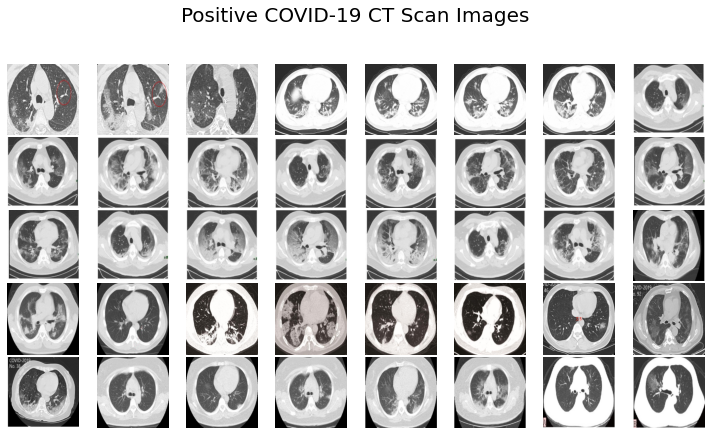

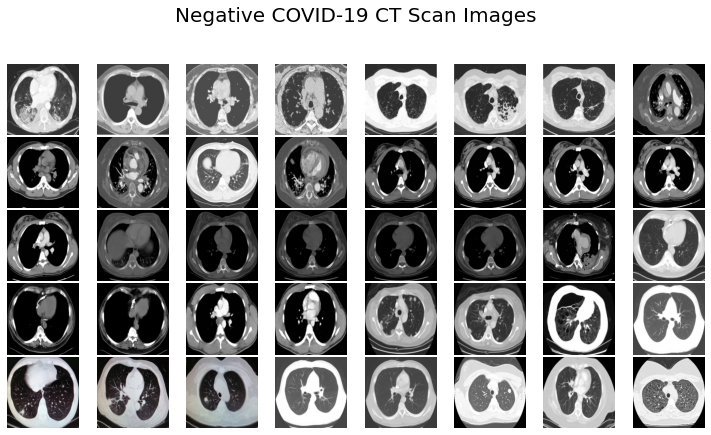

In [6]:
# Plotting the Positive COVID and Negative COVID datasets

plot_images_from_datasets(covid_images, 'Positive COVID-19 CT Scan Images')
plot_images_from_datasets(noncovid_images, 'Negative COVID-19 CT Scan Images')

# Convert to array and Normalize to interval
covid_images = np.array(covid_images) / 224
noncovid_images = np.array(noncovid_images) / 224

# Split the dataset into train,test and concatenate the datasets

In [6]:
# Split into training and testing sets 

# COVID Positive 
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)

#COVID Negative
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

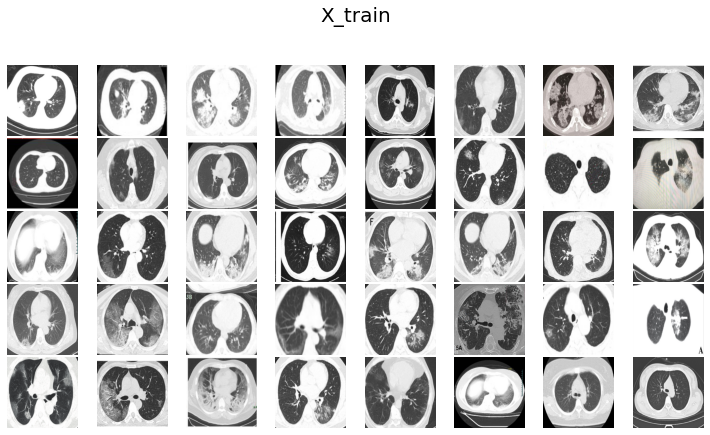

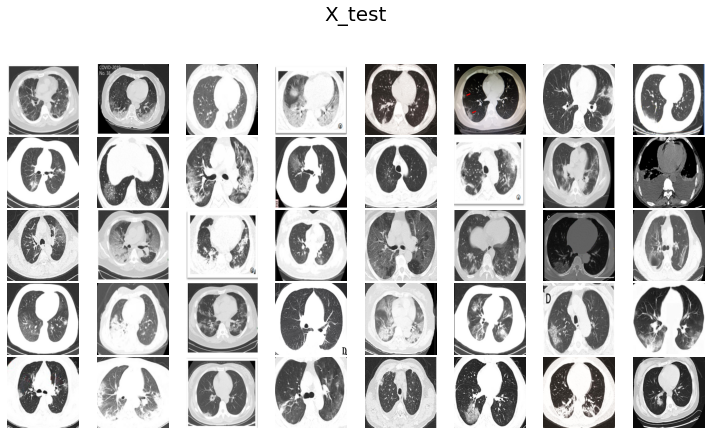

In [7]:
plot_images_from_datasets(covid_x_train, 'X_train')
plot_images_from_datasets(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

In [8]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [9]:
# Building Model
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [10]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

  ...
    to  
  ['...']
Train for 37.25 steps, validate on 150 samples
Epoch 1/200
38/37 [==============================] - 343s 9s/step - loss: 4.7835 - accuracy: 0.6628 - val_loss: 3.5498 - val_accuracy: 0.6533
Epoch 2/200
38/37 [==============================] - 287s 8s/step - loss: 4.2299 - accuracy: 0.7215 - val_loss: 9.7604 - val_accuracy: 0.5267
Epoch 3/200
38/37 [==============================] - 274s 7s/step - loss: 3.4831 - accuracy: 0.7752 - val_loss: 3.6480 - val_accuracy: 0.7267
Epoch 4/200
38/37 [==============================] - 273s 7s/step - loss: 3.5825 - accuracy: 0.7919 - val_loss: 7.1897 - val_accuracy: 0.6067
Epoch 5/200
38/37 [==============================] - 273s 7s/step - loss: 3.3141 - accuracy: 0.8054 - val_loss: 4.7946 - val_accuracy: 0.7467
Epoch 6/200
38/37 [==============================] - 273s 7s/step - loss: 3.5937 - accuracy: 0.7970 - val_loss: 5.3613 - val_accuracy: 0.6800
Epoch 7/200
38/37 [==============================] - 273s 7s/step - loss: 3.

In [ ]:
# Save Model and Weights
model.save('resnet_ct.h5')
model.save_weights('resnet_weights_ct.hdf5')

In [ ]:
# Load saved model
model = load_model('resnet_ct.h5')

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin,y_pred_bin))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_accuracy.png')
plt.show()


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_loss.png')
plt.show()